# Modelling
<u>Tests using the following models :</u>
* Linear regression
* Random forest regressor
* Ridge and Lasso Regularization (add on to linear modelling?)

<u> Tests using the following variables:</u>
* Weather variables (rain, temperature, windspeed)
* Time variables (Day of week, month, year, time of day, public holiday)
* Sensor environment variables:
    * Sensor_id
    * Betweenness of the street 
    * Buildings in proximity to the sensor
    * Landmarks in proximity to the sensor  
    * Furniture in proximity to the sensor    
    * Lights in proximity to the sensor   


Normalise variables: should this be with MinMax or StandardScaler??


Process:
* Keep only data from sensor's with relatively complete data
* Split data into training ( 75%) and test (25%)
* Define the models to use in testing (linear regression, random forest, xgboost)
* Define the error metrics to use in evaluating the model performance

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor 
import xgboost as xgb
from sklearn.pipeline import Pipeline
import folium
import branca.colormap as cm
from eli5.sklearn import PermutationImportance
import joblib
import os
import psutil

from Functions import *

In [2]:
def prepare_x_y_data(buffer_size_m):
    # Read in formatted data
    data = pd.read_csv("../Cleaned_data/FormattedDataForModelling/formatted_data_for_modelling_allsensors_{}.csv".format(buffer_size_m), 
                       index_col = False)
    data = data.fillna(0)
    
    ### Delete unneeded columns - we currently include data from all sensors (even incomplete ones)
    sensor_ids = data['sensor_id']
    data = data.drop(['sensor_id'],axis=1) # don't want this included
    # Get rid of columns in which none of the sensors have a value
    for column in data.columns:
        if np.nanmax(data[column]) ==0:
            del data[column]
            
    # Filter columns using the regex pattern in function input
    regex_pattern = 'buildings$|furniture$|landmarks$'
    data = data[data.columns.drop(list(data.filter(regex=regex_pattern)))].copy()
    
    ### Add a random variable (to compare performance of other variables against)
    rng = np.random.RandomState(seed=42)
    data['random'] = np.random.random(size=len(data))
    data["random_cat"] = rng.randint(3, size=data.shape[0])
    
    ## Prepare data for modelling 
    ### Split into predictor/predictand variables
    Xfull = data.drop(['hourly_counts'], axis =1)
    Yfull = data['hourly_counts'].values
    
    ### Date based variables: Option 1 - Sin/Cos variables
    # data_time_columns = Xfull[['day_of_month_num', 'time', 'weekday_num', 'time_of_day']]
    # Xfull = Xfull.drop(['day_of_month_num', 'time', 'weekday_num', 'time_of_day','year', 'month','day', 'datetime', 'month_num'],axis=1)
    
    ### Date based variables: Option 2 - Create Dummy Variables
    for date_col in ['day', 'month',]:
        date_col_dummy =  pd.get_dummies(Xfull[date_col], drop_first = True)
        if date_col =='month':
            date_col_dummy.columns= prepend(date_col_dummy.columns.values, 'month_')
        # if date_col =='year':
            # date_col_dummy.columns= prepend(date_col_dummy.columns.values, 'year_')
        Xfull = pd.concat([Xfull, date_col_dummy],axis=1)
        del Xfull[date_col]
        # data_time_columns = data[['time']]
    Xfull = Xfull.drop(['datetime', 'time_of_day',  'time', 'weekday_num','month_num','Sin_month_num', 'Cos_month_num',
            'Sin_weekday_num', 'Cos_weekday_num', "day_of_month_num" ],axis=1)
    
    ### Store the (non Sin/Cos) time columns and then remove them (Need them later to segment the results by hour of the day)
    # data_time_columns = Xfull[['day_of_month_num', 'time', 'weekday_num', 'time_of_day']]
    # Xfull = Xfull.drop(['day_of_month_num', 'time', 'weekday_num', 'time_of_day','year', 'month','day', 'datetime', 'month_num'],axis=1)
    return Xfull, Yfull

## Define model pipelines (linear regression, random forest and XGBoost)
Include process to scale the data

In [3]:
lr_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['linear_regressor',LinearRegression()]])
rf_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['rf_regressor', RandomForestRegressor(random_state = 1, n_jobs = 10)]])
xgb_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['xgb_regressor',xgb.XGBRegressor(random_state=1, n_jobs = 16)]])
et_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['et_regressor',ExtraTreesRegressor (random_state = 1, n_jobs = 16)]])

## Run models with cross-validation

### Define the error metrics for the cross-validation to return, and the parameters of the cross validatio

In [4]:
error_metrics = ['neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']
cv_parameters = KFold(n_splits=10, random_state=1, shuffle=True)

### Loop through each combination of the models, and the variables to include in the modelling

In [7]:
buffer_size_m=500
Xfull, Yfull = prepare_x_y_data(buffer_size_m)

In [6]:
# start = time()
# print("running cross_validate")
# model_output = cross_validate(rf_model_pipeline, Xfull, Yfull, cv=cv_parameters, scoring=error_metrics, error_score="raise")
# print("ran cross_validate")   
# end = time()
# print('Ran in {} minutes'.format(round((end - start)/60),2))

In [15]:
# model_name = {"xgb_regressor":xgb_model_pipeline}
model = rf_model_pipeline
model_name = 'rf_regressor'
regex_name = 'withsubtypes'
regex = 'buildings$|furniture$|landmarks$'
cv_parameters = KFold(n_splits=10, random_state=1, shuffle=True)

#### run cross validate to get error scores
start = time()
print("running cross_validate")
# model_output = cross_validate(rf_model_pipeline, Xfull, Yfull, cv=cv_parameters, scoring=error_metrics, error_score="raise")
# print("ran cross_validate")   
# end = time()
# print('Ran cross_validate {} minutes'.format(round((end - start)/60),2))

# error_metrics_df =pd.DataFrame({'mae': round(abs(model_output['test_neg_mean_absolute_error'].mean()),2), 
#               'map': round(abs(model_output['test_neg_mean_absolute_percentage_error'].mean()),2),
#               'r2': round(abs(model_output['test_r2'].mean()),2), 
#               'rmse': round(abs(model_output['test_neg_root_mean_squared_error'].mean()),2)},
#              index =["{}".format(buffer_size_m)])

#### Run cross_val_predict to get predictions
print("running cross_val_predict")
predictions = cross_val_predict(model, Xfull,Yfull,cv=cv_parameters)
print("ran cross_val_predict")   
end = time()
print('Ran cross_val_predict in {} minutes'.format(round((end - start)/60),2))

predictions.to_csv('PickleFiles/CV/{}/{}_predictions_{}m.csv'.format(buffer_size_m, model_name,buffer_size_m),index=False)    

In [14]:
predictions_df=pd.DataFrame(predictions)
predictions_df.to_csv('PickleFiles/CV/{}/{}_predictions_{}m.csv'.format(buffer_size_m, model_name,buffer_size_m),index=False)   

In [ ]:
# rf_model = joblib.load('PickleFiles/CV/{}/{}_cv_estimators.pkl'.format(200,'linear_regressor'))
# xgb_model = joblib.load('PickleFiles/CV/{}/{}_cv_estimators.pkl'.format(200,'xgb_regressor'))

### Plot the predicted vs actual values from the CV process
Within cross validation each data point is included in the test set only once and thus despite their beng multiple cross-validation folds, each true value of Y has only one associated prediction 

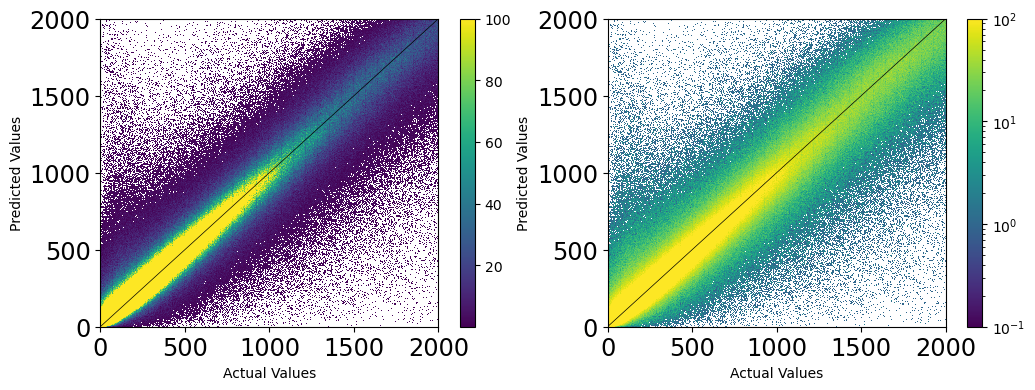

In [16]:
fig, axs = plt.subplots(ncols=2, figsize = (12,4))
using_datashader(axs[0], Yfull, predictions, 'linear')
axs[0].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[0].set_ylabel("Predicted Values", size=10)
axs[0].set_xlabel("Actual Values", size=10)
axs[0].xaxis.set_tick_params(labelsize='xx-large')
axs[0].yaxis.set_tick_params(labelsize='xx-large')
axs[0].set_xlim([0, 2000])
axs[0].set_ylim([0, 2000])
using_datashader(axs[1], Yfull, predictions, 'log')
axs[1].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[1].set_ylabel("Predicted Values", size=10)
axs[1].set_xlabel("Actual Values", size=10)
axs[1].xaxis.set_tick_params(labelsize='xx-large')
axs[1].yaxis.set_tick_params(labelsize='xx-large')
axs[1].set_xlim([0, 2000])
axs[1].set_ylim([0, 2000]);

### Print the accuracy scores

In [17]:
# error_metric_scores

### Feature importances from within cross-validation
If reporting feature importances from the model, then would use those from fitting the final model on the full dataset. However, this is useful as a measure of the stability of the feature importances that the model reports

In [18]:
feature_importances_df = feature_importance_scores["rf_regressor_withsubtypes"].copy()
feature_importances_df.reset_index(inplace=True)
feature_importances_df.rename(columns={'level_0':'Variable'},inplace=True)

NameError: name 'feature_importance_scores' is not defined

#### Top 10 features for each estimator

In [ ]:
important_columns=pd.DataFrame()
for column in feature_importances_df.columns[1:]:
    this_col = feature_importances_df[['Variable', column]]
    important_columns[column] = this_col.sort_values(column, ascending = False)['Variable'].tolist()[0:10]
important_columns    

In [ ]:
pi_raw = []
pi_ls = []
for estimator in estimators[:3]:
    pi, pi_raw = find_permutation_importance(estimator['rf_regressor'], Xfull, Yfull, n_iter=3)  
    pi_ls.append(pi)
    pi_raw.append(pi_raw)

### Find permutation importance from within Cross validation

In [ ]:
important_columns=pd.DataFrame()
for i in list(range(0,len(pi_ls))):
    test=pi_ls[i].sort_values('importance', ascending = False)[0:25]
    test.reset_index(inplace=True, drop=True)
    important_columns["PI{}".format(i)] = test['feature']
important_columns

### Find the error in the predictions broken down by hour and sensor

In [ ]:
# Get all relevant data in one dataframe
df =pd.DataFrame({'Predictions': predictions, 'Real_vals':Yfull, 'Hour': data_time_columns['time'],
                  'Weekday': data_time_columns['weekday_num'] ,'Sensor_id':sensor_ids, 'AbsolouteError':abs(Yfull-predictions)})
# Add hour of week variable
df['hour_of_week'] = df.apply (lambda row: label_hour_of_week(row), axis=1)
# Sort by this variable
df=df.sort_values(by=['Weekday', 'Hour'])
df.head()

In [ ]:
# Lists to store errors for each hour/sensor
hourly_mapes = []
hourly_maes = []
hourly_mae_stds = []
hourly_means= []
hourly_stds= []

sensorly_mapes =[]
sensorly_maes =[]
sensorly_means = []

hourofweekly_mapes = []
hourofweekly_maes = []
hourofweekly_means= []
hourofweekly_stds= []
hourofweekly_mae_stds = []

# Loop through the hours and add the results to the list
for hour_of_week in df['hour_of_week'].unique():
    # print("At {} o'clock".format(hour))
    one_hour_of_week = df[df['hour_of_week'] ==hour_of_week]
    # print("Error is {}% of the average hourly count".format(round(one_hour['AbsolouteError'].mean()/one_hour['Real_vals'].mean()*100,1)))
    hourofweekly_mapes.append(one_hour_of_week['AbsolouteError'].mean()/one_hour_of_week['Real_vals'].mean()*100)
    hourofweekly_maes.append(round(one_hour_of_week['AbsolouteError'].mean(),1))
    hourofweekly_mae_stds.append(round(one_hour_of_week['AbsolouteError'].std(),1))
    hourofweekly_means.append(round(one_hour_of_week['Real_vals'].mean(),1))
    hourofweekly_stds.append(round(one_hour_of_week['Real_vals'].std(),1))

# Loop through the hours and add the results to the list
for hour in range(0,24):
    # print("At {} o'clock".format(hour))
    one_hour = df[df['Hour'] ==hour]
    # print("Error is {}% of the average hourly count".format(round(one_hour['AbsolouteError'].mean()/one_hour['Real_vals'].mean()*100,1)))
    hourly_mapes.append(one_hour['AbsolouteError'].mean()/one_hour['Real_vals'].mean()*100)
    hourly_maes.append(round(one_hour['AbsolouteError'].mean(),1))
    hourly_mae_stds.append(round(one_hour['AbsolouteError'].std(),1))
    hourly_means.append(round(one_hour['Real_vals'].mean(),1))
    hourly_stds.append(round(one_hour['Real_vals'].std(),1))
    
# Loop through the sensors and add the results to the list
for sensor_id in np.sort(sensor_ids.unique()):
    # print("At sensor {}".format(sensor_id))
    one_sensor = df[df['Sensor_id'] ==sensor_id]
    # print("Error is {}% of the average hourly count".format(round(one_sensor['AbsolouteError'].mean()/one_sensor['Real_vals'].mean()*100,1)))
    sensorly_mapes.append(round(one_sensor['AbsolouteError'].mean()/one_sensor['Real_vals'].mean()*100,1))
    sensorly_maes.append(round(one_sensor['AbsolouteError'].mean(),1))
    sensorly_means.append(one_sensor['Real_vals'].mean())

### Plot the errors per hour of week

In [ ]:
labels = ['1am','2am','3am','4am','5am','6am','7am','8am','9am','10am','11am','12',
         '1pm','2pm','3pm','4pm','5pm','6pm','7pm','8pm','9pm','10pm','11pm','12',]*7

In [ ]:
fig,axs =plt.subplots(nrows=3,figsize =(24,20), sharex=True)
axs[0].bar(np.sort(df['hour_of_week'].unique()),hourofweekly_means)#,  yerr=hourofweekly_stds  )
axs[0].set_title('Mean Values', fontsize=60)
axs[1].bar(np.sort(df['hour_of_week'].unique()),hourofweekly_maes)#, yerr=hourofweekly_mae_stds   )
axs[1].set_title('Mean Absoloute Error', fontsize=60)
axs[2].bar(np.sort(df['hour_of_week'].unique()),hourofweekly_mapes )
axs[2].set_title('Mean Absoloute Percentage Error', fontsize=60)
# axs[2].tick_params(axis='x')

# Removes weird whitespace from the start
axs[0].set_xlim([1,len(df['hour_of_week'].unique()[::3])])
axs[1].set_xlim([1,len(df['hour_of_week'].unique()[::3])])
axs[2].set_xlim([1,len(df['hour_of_week'].unique()[::3])])

# Axis labels
axs[2].set_xticks(list(range(1,len(labels)))[::6], fontsize=40)
axs[2].set_xticklabels(labels[::6], fontsize=40, rotation = 55)

params = {'ytick.labelsize': 50}
plt.rcParams.update(params)

for i in range(1,7):
    axs[0].axvline(x = 24*i, color = 'black', label = 'axvline - full height')
    axs[1].axvline(x = 24*i, color = 'black', label = 'axvline - full height')
    axs[2].axvline(x = 24*i, color = 'black', label = 'axvline - full height')
    
fig.savefig('Figs/Errors/Error_by_hour_of_week.pdf')
fig.savefig('Figs/Errors/Error_by_hour_of_week.jpg')

### Plot errors by hour of day

In [ ]:
fig,axs =plt.subplots(ncols=3, figsize =(12,3))
axs[0].bar(np.sort(df['Hour'].unique()),hourly_mapes )
axs[0].set_title('Mean Absoloute Percentage Error');
axs[1].bar(np.sort(df['Hour'].unique()),hourly_maes )
axs[1].set_title('Mean Absoloute Error')
axs[2].bar(np.sort(df['Hour'].unique()),hourly_means )
axs[2].set_title('Mean')

axs[0].set_xticks(list(range(1,25)))
axs[0].set_xticklabels(df['Hour'].unique(), rotation=90, size = 8);
axs[1].set_xticks(list(range(1,25)))
axs[1].set_xticklabels(df['Hour'].unique(), rotation=90, size = 8);
axs[2].set_xticks(list(range(1,25)))
axs[2].set_xticklabels(df['Hour'].unique(), rotation=90, size = 8);

### Plot the errors by sensor

In [ ]:
### Read in Melbourne sensor location spatial data
melbourne_sensors = pd.read_csv("../Data/melbourne_locations.csv")
melbourne_sensors.rename(columns={'sensor_description': 'Name'}, inplace = True)

In [ ]:
sensorly_errors_df = pd.DataFrame({'sensor_id':np.sort(sensor_ids.unique()),'MAPE':sensorly_mapes,'MAE':sensorly_maes,
                                  'Mean':sensorly_means})
melbourne_sensors = pd.merge(sensorly_errors_df, melbourne_sensors, on='sensor_id', how='left')

In [ ]:
linear = cm.LinearColormap(["green", "yellow", "red"], vmin=melbourne_sensors['Mean'].min(),
                           vmax=melbourne_sensors['Mean'].max())

# Plot
melbourne_map = folium.Map(location=[melbourne_sensors.Latitude.mean(),
                           melbourne_sensors.Longitude.mean()], zoom_start=14, control_scale=True, min_zoom = 13)

for _, row in melbourne_sensors.iterrows():
    folium.CircleMarker([row.Latitude, row.Longitude],
                      popup=row.sensor_id,
                      radius=8,  fill=True, fill_opacity = 1,
                      color = linear(row.Mean), fill_color = linear(row.Mean),
                      ).add_to(melbourne_map)


linear.caption = "Mean hourly values"
linear.add_to(melbourne_map)
melbourne_map

import io
from PIL import Image

img_data = melbourne_map._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('image.png')

In [ ]:
linear = cm.LinearColormap(["green", "yellow", "red"], vmin=melbourne_sensors['MAPE'].min(), vmax=melbourne_sensors['MAPE'].max())

# Plot
melbourne_map = folium.Map(location=[melbourne_sensors.Latitude.mean(),
                           melbourne_sensors.Longitude.mean()], zoom_start=14, control_scale=True, min_zoom = 13)

for _, row in melbourne_sensors.iterrows():
    folium.CircleMarker([row.Latitude, row.Longitude],
                      popup=row.sensor_id,
                      radius=8,  fill=True, fill_opacity = 1,
                      color = linear(row.MAPE), fill_color = linear(row.MAPE),
                      ).add_to(melbourne_map)


linear.caption = "Mean Absoloute Percentage Error"
linear.add_to(melbourne_map)
melbourne_map

In [ ]:
linear = cm.LinearColormap(["green", "yellow", "red"], vmin=melbourne_sensors['MAE'].min(), vmax=melbourne_sensors['MAE'].max())

# Plot
melbourne_map = folium.Map(location=[melbourne_sensors.Latitude.mean(),
                           melbourne_sensors.Longitude.mean()], zoom_start=14, control_scale=True, min_zoom = 13)

for _, row in melbourne_sensors.iterrows():
    folium.CircleMarker([row.Latitude, row.Longitude],
                      popup=row.sensor_id,
                      radius=8,  fill=True, fill_opacity = 1,
                      color = linear(row.MAE), fill_color = linear(row.MAE),
                      ).add_to(melbourne_map)


linear.caption = "Mean Absoloute Error for the sensor"
linear.add_to(melbourne_map)
melbourne_map